# Microservicio de Autenticación

---

## 1. Introducción

El microservicio de autenticación es responsable de gestionar el registro, inicio de sesión y validación de usuarios mediante tokens JWT. Es un componente esencial en una arquitectura de microservicios, permitiendo la autenticación centralizada y segura de los usuarios.

**Tecnologías principales:**
- **Java 17:** Lenguaje principal del microservicio.
- **Spring Boot:** Framework para desarrollo rápido de aplicaciones Java.
- **Spring Security:** Manejo de autenticación y autorización.
- **PostgreSQL:** Base de datos relacional para almacenar usuarios.
- **JWT (JSON Web Token):** Para autenticación basada en tokens.
- **Docker & Kubernetes:** Contenerización y orquestación para despliegue escalable.

---

## 2. Arquitectura y Estructura del Proyecto

El proyecto sigue una arquitectura limpia, separando las responsabilidades en diferentes capas:

```
auth-microservice/
│
├── src/
│   ├── main/
│   │   ├── java/com/develop/auth_microservice/
│   │   │   ├── application/      # Lógica de negocio y servicios
│   │   │   ├── domain/           # Modelos de dominio y contratos
│   │   │   ├── infrastructure/   # Adaptadores, repositorios, seguridad
│   │   │   └── presentation/     # Controladores REST y manejo de errores
│   │   └── resources/
│   │       └── application.properties # Configuración de Spring Boot
│   └── test/                     # Pruebas unitarias y de integración
│
├── k8s/                          # Archivos de despliegue para Kubernetes
│   ├── deployment.yaml
│   └── service.yaml
├── Dockerfile                    # Construcción de la imagen Docker
└── README.md                     # Documentación del proyecto
```

---

## 3. Despliegue

### Local

1. Clona el repositorio.
2. Configura las variables de entorno en `application.properties` o como variables del sistema.
3. Ejecuta el microservicio:
   ```bash
   ./mvnw spring-boot:run
   ```
4. Accede a `http://localhost:8082`.

### Docker

1. Construye la imagen:
   ```bash
   docker build -t auth-microservice:latest .
   ```
2. Ejecuta el contenedor:
   ```bash
   docker run -p 8082:8082 --env-file .env auth-microservice:latest
   ```

### Kubernetes

1. Crea el Secret con las credenciales:
   ```bash
   kubectl create secret generic credentials \
     --from-literal=username=USUARIO_BD \
     --from-literal=password=CONTRASEÑA_BD \
     --from-literal=url=jdbc:postgresql://host:puerto/bd \
     --from-literal=jwt=CLAVE_SECRETA_JWT
   ```
2. Aplica los manifiestos:
   ```bash
   kubectl apply -f k8s/deployment.yaml
   kubectl apply -f k8s/service.yaml
   ```

#### Fragmento relevante de `deployment.yaml`:

```yaml
# filepath: k8s/deployment.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: auth-microservice
spec:
  replicas: 1
  selector:
    matchLabels:
      app: auth-microservice
  template:
    metadata:
      labels:
        app: auth-microservice
    spec:
      containers:
        - name: auth-microservice
          image: juanhoyos/microservice:auth-v8
          ports:
            - containerPort: 8082
          env:
            - name: SERVER_PORT
              value: "8082"
            - name: DATABASE_USERNAME
              valueFrom:
                secretKeyRef:
                  name: credentials
                  key: username
            - name: DATABASE_PASSWORD
              valueFrom:
                secretKeyRef:
                  name: credentials
                  key: password
            - name: DATABASE_URL
              valueFrom:
                secretKeyRef:
                  name: credentials
                  key: url
            - name: JWT_SECRET_KEY
              valueFrom:
                secretKeyRef:
                  name: credentials
                  key: jwt
          resources:
            limits:
              memory: "512Mi"
              cpu: "500m"
            requests:
              memory: "256Mi"
              cpu: "250m"
```

---

## 4. Configuración

**Variables de entorno requeridas:**

| Variable           | Descripción                                    |
|--------------------|------------------------------------------------|
| SERVER_PORT        | Puerto donde escucha el microservicio          |
| DATABASE_USERNAME  | Usuario de la base de datos PostgreSQL         |
| DATABASE_PASSWORD  | Contraseña de la base de datos                 |
| DATABASE_URL       | URL de conexión a PostgreSQL                   |
| JWT_SECRET_KEY     | Clave secreta para firmar y validar JWT        |

Estas variables pueden ser configuradas en el entorno, en el archivo `.env`, o mediante un Secret en Kubernetes.

---

## 5. Endpoints

### POST `/auth/register`
Registra un nuevo usuario.

- **Body:**
  ```json
  {
    "email": "usuario@example.com",
    "password": "contraseña123",
    "rol": "USER"
  }
  ```
- **Respuestas:**
  - `200 OK`: Usuario registrado exitosamente.
  - `400 Bad Request`: Datos inválidos o usuario ya existente.

### POST `/auth/login`
Autentica un usuario y retorna un token JWT.

- **Body:**
  ```json
  {
    "email": "usuario@example.com",
    "password": "contraseña123"
  }
  ```
- **Respuestas:**
  - `200 OK`: Token JWT.
  - `401 Unauthorized`: Credenciales incorrectas.
  - `400 Bad Request`: Datos inválidos.

### GET `/auth/validate`
Valida un token JWT.

- **Query Params:**
  - `token`: Token JWT.
  - `email`: Email del usuario.

- **Respuestas:**
  - `200 OK`: Token válido.
  - `400 Bad Request`: Token inválido o parámetros faltantes.

---

## 6. Modelos de Datos

### Usuario (Auth)
```json
{
  "idUser": 1,
  "email": "usuario@example.com",
  "password": "hash_pbkdf2",
  "rol": "USER",
  "salt": "base64_salt"
}
```
- **email:** Obligatorio, formato válido.
- **password:** Obligatorio, mínimo 6 caracteres (almacenada hasheada).
- **rol:** Por defecto "USER".
- **salt:** Salt aleatorio para el hash de la contraseña.

### LoginRequest
```json
{
  "email": "usuario@example.com",
  "password": "contraseña123"
}
```

---

## 7. Seguridad

- **Contraseñas:**  
  Se almacenan usando hashing PBKDF2 con salt único por usuario, lo que protege contra ataques de diccionario y rainbow tables.
- **JWT:**  
  Los tokens JWT se generan y validan usando una clave secreta definida en la variable de entorno. El token contiene información del usuario y su rol.
- **Validaciones:**  
  - Email: formato válido y no vacío.
  - Contraseña: mínimo 6 caracteres.
- **Roles:**  
  El campo `rol` permite diferenciar permisos de usuario y puede ser extendido para control de acceso.

---

## 8. Errores y Manejo de Excepciones

El microservicio retorna mensajes claros y códigos HTTP apropiados ante errores.

**Ejemplos:**

- **Registro - Email inválido:**
  ```json
  HTTP/1.1 400 Bad Request
  {
    "email": "El email debe tener un formato válido"
  }
  ```
- **Login - Credenciales incorrectas:**
  ```json
  HTTP/1.1 401 Unauthorized
  Credenciales incorrectas
  ```
- **Validación de token - Token inválido:**
  ```json
  HTTP/1.1 400 Bad Request
  Token inválido
  ```

---

## 9. Diagramas de Flujo

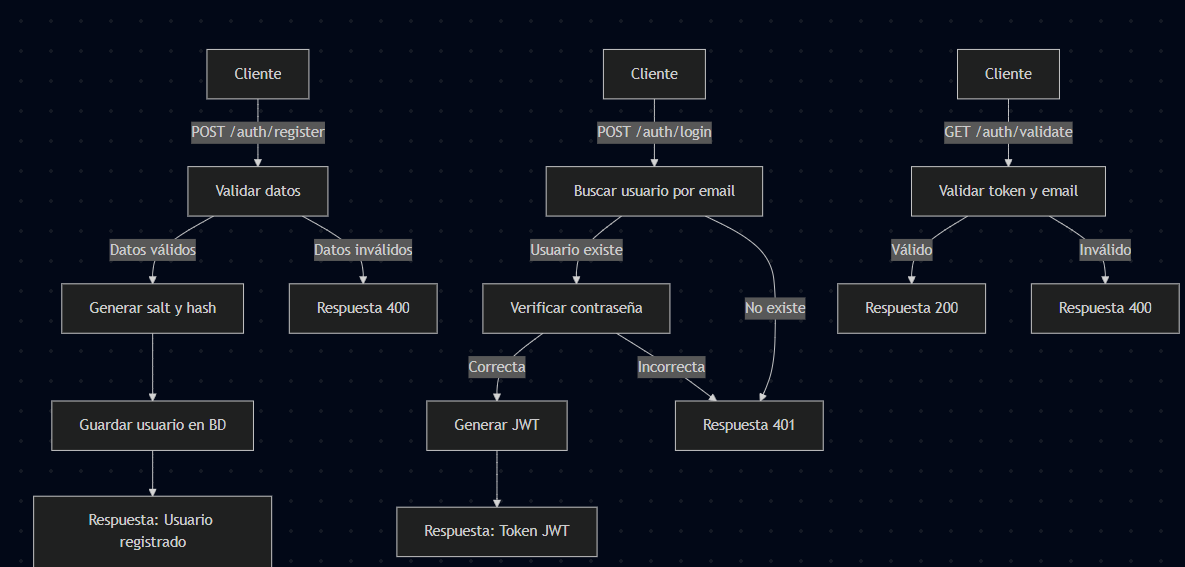

---

